# COMP47590: Advanced Machine Learning
# Assignment 1: The Super Learner

## Import Packages 

In [2]:
from IPython.display import display, HTML, Image

from sklearn.base import BaseEstimator, ClassifierMixin

# Add more packages as required

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
import seaborn as sns

from sklearn.model_selection import learning_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.svm import SVC 
from sklearn.ensemble import BaggingClassifier
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import naive_bayes
from sklearn import metrics
from scipy.spatial import distance

%matplotlib inline
#%qtconsole

## Define Super Learner Classifier

The *Super Learner* is a heterogeneous stacked ensemble classifier. This is a classification model that uses a set of base classifiers of different types, the outputs of which are then combined in another classifier at the stacked layer. The Super Learner was described in [(van der Laan et al, 2007)](https://pdfs.semanticscholar.org/19e9/c732082706f39d2ba12845851309714db135.pdf) but the stacked ensemble idea has been around for a long time. 

Figure 1 shows a flow diagram of the Super Learner process (this is from (van der Laan et al, 2007) and the process is also described in the COMP47590 lecture "[COMP47590 2017-2018 L04 Supervised Learning Ensembles 3](https://www.dropbox.com/s/1ksx94nxtuyn4l8/COMP47590%202017-2018%20L04%20Supervised%20Learning%20Ensembles%203.pdf?raw=1)"). The base classifiers are trained and their outputs are combined along with the training dataset labels into a training set for the stack layer classifier. To avoid overfitting the generation of the stacked layer training set uses a k-fold cross validation process (described as V-fold in Figure 1). To further add variety to the base estimators a bootstrapping selection (as is used in the bagging ensemble approach).
 
![Super Learner Process Flow](SuperLearnerProcessFlow.png "Logo Title Text 1")
Figure 1: A flow diagram for the Super Learner


### Define the SuperLearnerClassifier Class

In [3]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class SuperLearnerClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a 
    aggregation model at the aggregation layer. A k-fold cross validation is used
    to gnerate training data for the stack layer model.

    
    Attributes
    
    _init_ : This attribute is the constructor for the classifier objects which initializes them with default values.
    
    fit: This attribute requires X i.e the Data and y i.e the Labels as an input to perform training of Super Learner Classifier
    
    predict: Super Learner predict method predict the labels and return them.
    
    predict_proba: Super Learner predict_proba method predicts the probability based labels.
    
    getBaseClassifierPerformance: To find the diversity and predictive power of the base estimators we are using for the 
                                  Super Learner Classifier
    

    """
    # Constructor for the classifier object
    def __init__(self,modelslists=None,aggregator=None,Vfold=None,probability_flag=False,original_features=False):
        
        """
        Setup a SuperLearner classifier .
        
        Parameters:
        -modelslists: Here the superlearner algorithm will contain some paramters like the list of base estimators 
        (heterogenous models).
        
        -aggregator: This parameter specifies which model is used at stacked layer.
        
        -probability flag: To decide whether the output provided by the base estimators will be label based or probability based and these outputs will be given as an input to stack layer.
        
        -V-fold: The folds on which the data of base estimators will be splitted i.e the cross validation will happen.
        
        -original_features: This flag specifies if we need to add original features to the Stack layer.

        """  
        #Initializing the parameters with their default values
        self.probability_flag=probability_flag
        self.modelslists=modelslists
        self.aggregator=aggregator
        self.original_features=original_features  
        self.Vfolds=Vfold 
    

    # The fit function to train a classifier
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Return""Build a SuperLearner classifier from the training set (X, y).
        s
        -------
        self : object
        
        """       
   
    #TASK 1: To implement the basic charecteristics of Super Learner Classifier (Heterogenous Base estimators with some default parameters setting.)
    
    #Define all the default models internally, if the user doesn't know what all models should be used.
        if self.modelslists==None:
            DecTreeClf= tree.DecisionTreeClassifier()
            SVMClf= SVC(probability=True)
            KnnClf=KNeighborsClassifier(5)
            SGDClf=linear_model.SGDClassifier()
            LogClf=linear_model.LogisticRegression()
            NBClf=naive_bayes.GaussianNB()
            RFClf=RandomForestClassifier()
            self.modelslists=[DecTreeClf,RFClf,KnnClf,SVMClf,LogClf,NBClf]
       
    #Check the Vfolds value require to perform vfolds cross validations on base estimators
        if self.Vfolds==None:
            kfold=KFold(n_splits=5)
        else:
            kfold=KFold(n_splits=Vfold)
     
    #Declare the DataFrames that will be used in the method       
        pred_array_final=pd.DataFrame() #To store the final Stack Layer Data Frame
        pred_label_final=pd.DataFrame() #To store the final Stack Layer Target Labels
        pred_array=pd.DataFrame()       #To store the data from the predicted labels from the base estimators
        proba_dataframe=pd.DataFrame()  #To store the probability values of each model

        
        train_array=X.values #Take the values from training dataset X as dataframe values
        label_array=y #Take the label data y
        
        feature_list=X.columns.values   #Get the orginal descriptive feature list from the base data. (For TASK 8)
        
        #The below loop is use split the input data into k-folds(train and test) of the the base estimators. (Cross Validation)
        for train_index, test_index in kfold.split(train_array):
            
            X_train, X_test=train_array[train_index], train_array[test_index]
            y_train, y_test=label_array[train_index], label_array[test_index]
                    
        #TASK 3: The following code takes a parameter probability_flag to decide whether the Stack Layer classifier should be trained on label outputs of Base Estimators or probability outputs of Base Estimators
            counter=1
            if self.probability_flag==False:
                pred_array=pd.DataFrame()
                for lists in self.modelslists:
                    lists.fit(X_train,y_train)
                    modelname='Model' + str(counter)
                    counter+=1
                    pred_array[modelname]=pd.Series(lists.predict(X_test))  #the dataframe to store prediction data from each model
                    
            else:
                proba_dataframe=[]
                for lists in self.modelslists:
                    lists.fit(X_train,y_train)
                    proba_values=pd.DataFrame(lists.predict_proba(X_test), columns= ['Label' +str(i) for i in range(counter,counter+10)]) #dataframe to store probability predictions data from each model
                    counter+=10
                    proba_dataframe.append(proba_values)
                pred_array=pd.concat(proba_dataframe, axis=1)
            
           
        #TASK 8 : To check if original features flag is true to add original Descriptive Features to the input at stack layer
            if self.original_features == True:    
                extra_feature_pred_dataframe=pd.DataFrame(X_test,columns=feature_list) #create a new dataframe to add the original descriptive feature list.
                pred_array=pd.concat([pred_array,extra_feature_pred_dataframe],axis=1) #now concat the new original list dataframe and the stacked layer dataframe
            
            pred_array_final=pd.concat([pred_array_final,pred_array]) # Stack Layer Data frame formed
            pred_label_final=np.append(pred_label_final,y_test)       # Stack Layer target labels
            
        #To use whole data to train all the base estimators.         
        for i in range(len(self.modelslists)):
            (self.modelslists)[i].fit(X,y)
        
        #TASK 4: STACK LAYER CODE : To specifiy the types of estimators to be used at Stack Layer
        if self.aggregator == 'DecTreeClf':
            self.aggregator=tree.DecisionTreeClassifier()
        elif self.aggregator == 'LogClf':
            self.aggregator=linear_model.LogisticRegression()
        elif self.aggregator== 'KnnClf':
            self.aggregator=KNeighborsClassifier()
        else:
            self.aggregator=tree.DecisionTreeClassifier()
        
        (self.aggregator).fit(pred_array_final,pred_label_final)  #Training the stack layer by calling fit function
              
        # Return the classifier

        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        #Declare the DataFrames that are required for this function
        pred_array=pd.DataFrame()  #To store the data from the predicted labels from the base estimators
        pred_array_final=pd.DataFrame() #To store the final predicted data at Stack Layer
        proba_dataframe=pd.DataFrame()  #To store the probability values of each model

        #Read the original input features (TASK 8 requirement)
        feature_list=X.columns.values   #get the orginal descriptive feature list from the base data. 
        
        #TASK 3: The following code takes a parameter probability_flag to decide whether the Stack Layer classifier should be trained on label outputs of Base Estimators or probability outputs of Base Estimators
        counter=1
        if self.probability_flag==False:
            for lists in self.modelslists:
                modelname='Model' + str(counter)
                counter+=1
                pred_array[modelname]=pd.Series(lists.predict(X))
        
        else:
            proba_dataframe=[]
            for lists in self.modelslists:
                proba_values=pd.DataFrame(lists.predict_proba(X), columns= ['label' +str(i) for i in range(counter,counter+10)]) #dataframe to store probability predictions data from each model
                counter+=10
                proba_dataframe.append(proba_values)
            pred_array=pd.concat(proba_dataframe, axis=1)
            
        #TASK 8 : To check if original features flag is true to add original Descriptive Features to the input at stack layer
        if self.original_features == True:    
            extra_feature_pred_dataframe=pd.DataFrame(X,columns=feature_list) #create a new dataframe to add the original descriptive feature list.
            extra_feature_pred_dataframe=extra_feature_pred_dataframe.reset_index(drop=True)
            pred_array=pd.concat([pred_array,extra_feature_pred_dataframe],axis=1) #now concat the new original list dataframe and the stacked layer dataframe    
        
        pred_array_final=pd.concat([pred_array_final,pred_array],ignore_index=True) # Stack Layer Data frame formed
        
        #To predict the data got from the trained stack layer. It will store predicted labels.
        Observation_labels=self.aggregator.predict(pred_array_final)
        
        #Return the Observation labels i.e the predicted labels
        return Observation_labels
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """  Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """    
        #Declare the DataFrames that are required for this function
        pred_array=pd.DataFrame()  #To store the data from the predicted labels from the base estimators
        pred_array_final=pd.DataFrame() #To store the final predicted data at Stack Layer
        proba_dataframe=pd.DataFrame()  #To store the probability values of each model
        
        #Read the original input features (TASK 8 requirement)
        feature_list=X.columns.values   #get the orginal descriptive feature list from the base data. 
        
        #TASK 3: The following code takes a parameter probability_flag to decide whether the Stack Layer classifier should be trained on label outputs of Base Estimators or probability outputs of Base Estimators
        counter=1
        if self.probability_flag==False:
            for lists in self.modelslists:
                modelname='Model' + str(counter)
                counter+=1
                pred_array[modelname]=pd.Series(lists.predict(X))
        else:
            proba_dataframe=[]
            for lists in self.modelslists:
                proba_values=pd.DataFrame(lists.predict_proba(X), columns= ['label' +str(i) for i in range(counter,counter+10)]) #dataframe to store probability predictions data from each model
                counter+=10
                proba_dataframe.append(proba_values)
            pred_array=pd.concat(proba_dataframe, axis=1)
        
        #TASK 8 : To check if original features flag is true to add original Descriptive Features to the input at stack layer
        if self.original_features == True:    
            extra_feature_pred_dataframe=pd.DataFrame(X,columns=feature_list) #create a new dataframe to add the original descriptive feature list.
            extra_feature_pred_dataframe=extra_feature_pred_dataframe.reset_index(drop=True)
            pred_array=pd.concat([pred_array,extra_feature_pred_dataframe],axis=1) #now concat the new original list dataframe and the stacked layer dataframe    
        
        pred_array_final=pd.concat([pred_array_final,pred_array])  # Stack Layer Data frame formed
        
        #To predict the data got from the trained stack layer. It will store predicted probability labels.
        Observation_labels=(self.aggregator).predict_proba(pred_array_final) 
        
        #Return the Observation labels i.e the predicted probability labels
        return Observation_labels 
        
    #TASK 9 : To find the diversity and predictive power of the base estimators we are using for the Super Learner Classifier
    def getBaseClassifierPerformance(self,X,y):
        
        #To find DIVERSITY between the estimators using Spearman's Correlation Matrix
        count = 1
        correlation_df = pd.DataFrame() #Dataframe to store the correlation matrix
        
        #Loop to iterate over all the models and find the correlation on the predicted results of the classifier
        for my_model in self.modelslists:
            correlation_df['Model' + str(count)] = my_model.predict(X)
            count = count + 1
            correlation_matrix = correlation_df.corr(method='spearman') #using spearman correlation can help you getting proper scores to check diversity in the predictions of the models.

        #Plot the correlation matrix using seaborns heat maps
        print('Correlation Matrix for Base Models')
        sns.heatmap(correlation_matrix, 
                    xticklabels=correlation_matrix.columns.values,
                    yticklabels=correlation_matrix.columns.values)


        # Evaluate each model in turn
        accuracy_results = []
        labels = ['Model1','Model2','Model3','Model4','Model5','Model6']
        scoring = 'accuracy'
        for my_model in self.modelslists:
            cv_results = cross_val_score(my_model, X, y, cv=cv_folds, scoring=scoring)
            accuracy_results.append(cv_results)
            
        
        # boxplot algorithm comparison
        fig = plt.figure(figsize=(10,6))
        fig.suptitle('Classifiers Comparison')
        ax = fig.add_subplot(111)
        plt.boxplot(accuracy_results)
        ax.set_xticklabels(labels)
        plt.show()
        return self

### Test the SuperLearnerClassifier

Perform a simple test using the SuperLearnClassifier on the Iris dataset

In [4]:
from sklearn.datasets import load_iris
clf = SuperLearnerClassifier()
iris = load_iris()

irisdata=pd.DataFrame(np.c_[iris.data])
clf.fit(irisdata, iris.target)
scores=cross_val_score(clf, irisdata, iris.target, cv=10)
print(scores)

[ 0.93333333  0.93333333  1.          1.          0.93333333  0.86666667
  0.86666667  1.          1.          1.        ]


## Load & Partition Data

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [5]:
data_sampling_rate = 0.1

Setup the number of folds for all grid searches (should be 5 - 10)

In [6]:
cv_folds = 5

### Load Dataset

Load the dataset and explore it.

In [7]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
41437,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50503,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,64,131,49,0,0,0
18139,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9691,0,0,0,0,0,0,1,0,0,82,...,198,175,207,200,0,0,1,0,0,0
25928,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Pre-process & Partition Data

Perform data pre-processing and manipulation as required

In [8]:

X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])

X = X/255
print('Initial Shape: ', X.shape)

"""
Here we will split the data into 3-way hold out dataset. It will contain Training data and Test Data (split by 0.7).
The Training data will be further divided into trainingplus valid and validation data. This follows the 3-way hold out strategy.
This data will be use for training the classifier and evaluating it with different approaches.

"""
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.55/0.7)



Initial Shape:  (6000, 784)


## Train and Evaluate a Simple Model

Train a Super Learner Classifier using the prepared dataset

In [9]:
#TASK 6: 

#Define some 10 set of classifiers used as base estimators for Super Learner Classifier
DecTreeClf= tree.DecisionTreeClassifier()
SVMClf= SVC(probability=True)
KnnClf=KNeighborsClassifier(5)
SGDClf=linear_model.SGDClassifier(loss='log')
LogClf=linear_model.LogisticRegression()
NBClf=naive_bayes.GaussianNB()
RFClf=RandomForestClassifier()
ADBClf=AdaBoostClassifier()
BagClf=BaggingClassifier()
MLPClf=MLPClassifier()

#Create some lists of basemodels that can be passed to Super Learner Classifier
basemodellist1=[DecTreeClf,RFClf,KnnClf,NBClf,BagClf,LogClf]
basemodellist2=[DecTreeClf,SGDClf,SVMClf,KnnClf,NBClf,ADBClf]
basemodellist3=[SGDClf,LogClf,MLPClf,ADBClf,BagClf,KnnClf]

Vfold=5 #Specify the Vfolds which needs to be given to the superlearner classifier's base estimators.


In [10]:
# Training the Super Learner Classifier

superlearnerClf=SuperLearnerClassifier(basemodellist1,DecTreeClf,Vfold,probability_flag=False)

superlearnerClf.fit(X_train,y_train)


SuperLearnerClassifier(Vfold=None,
            aggregator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
            modelslists=[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_stat...lty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)],
            original_features=False, probability_flag=False)

Evaluate the trained classifier with predict funtion of superlearner classifier

In [11]:
y_pred = superlearnerClf.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(y_valid, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.806666666667
             precision    recall  f1-score   support

          0       0.75      0.89      0.81        89
          1       0.95      0.95      0.95        88
          2       0.64      0.68      0.66        79
          3       0.82      0.82      0.82        98
          4       0.64      0.67      0.65        96
          5       0.80      0.88      0.84        88
          6       0.66      0.44      0.53        84
          7       0.91      0.88      0.89        88
          8       0.92      0.93      0.92        86
          9       0.94      0.90      0.92       104

avg / total       0.81      0.81      0.80       900

Confusion Matrix


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
True,,,,,,,,,,,
0,79,0,4,2,0,0,4,0,0,0,89
1,0,84,0,3,0,0,0,0,1,0,88
2,1,1,54,1,18,0,3,0,1,0,79
3,5,2,2,80,5,0,3,0,1,0,98
4,0,1,18,3,64,1,9,0,0,0,96
5,0,0,0,0,0,77,0,5,1,5,88
6,21,0,6,7,11,0,37,0,2,0,84
7,0,0,0,0,0,9,0,77,1,1,88
8,0,0,1,1,2,2,0,0,80,0,86


Evaluate the trained classifier with predict_proba funtion of superlearner classifier

In [12]:
"""
To find the accuracy of probability scores is not straight forward. So here we will consider argument with maximum 
probability score so we use argmax(axis=1). However this will give similar result as that of predict function because the 
labels with max probability are only the labels returned by predict function. The below code just shows the way to find accuracy
if you are asked to used predict_proba function of classifier
"""
# Make a set of predictions for the training data
y_pred = superlearnerClf.predict_proba(X_valid)

# Print performance details

accuracy = metrics.accuracy_score(y_valid, y_pred.argmax(axis=1)) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred.argmax(axis=1)))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred.argmax(axis=1), rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.806666666667
             precision    recall  f1-score   support

          0       0.75      0.89      0.81        89
          1       0.95      0.95      0.95        88
          2       0.64      0.68      0.66        79
          3       0.82      0.82      0.82        98
          4       0.64      0.67      0.65        96
          5       0.80      0.88      0.84        88
          6       0.66      0.44      0.53        84
          7       0.91      0.88      0.89        88
          8       0.92      0.93      0.92        86
          9       0.94      0.90      0.92       104

avg / total       0.81      0.81      0.80       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,79,0,4,2,0,0,4,0,0,0,89
1,0,84,0,3,0,0,0,0,1,0,88
2,1,1,54,1,18,0,3,0,1,0,79
3,5,2,2,80,5,0,3,0,1,0,98
4,0,1,18,3,64,1,9,0,0,0,96
5,0,0,0,0,0,77,0,5,1,5,88
6,21,0,6,7,11,0,37,0,2,0,84
7,0,0,0,0,0,9,0,77,1,1,88
8,0,0,1,1,2,2,0,0,80,0,86


## Cross Validation Experiment (Task 2)

Perfrom a 10-fold cross validation experiment to evaluate the performance of the SuperLearnerClassifier

In [12]:
#To get the cross validation scores of the trained Super Learner Classifier. 
#The scoring mechanism is based on Accuracy scores.

scores=cross_val_score(superlearnerClf,X_train_plus_valid,y_train_plus_valid,cv=10)
print(scores)

[ 0.79529412  0.78588235  0.82783019  0.81279621  0.8047619   0.8
  0.82494005  0.80288462  0.83173077  0.80963855]


## Comparing the Performance of Different Stack Layer Approaches (Task 5)

Compare the performance of the ensemble when a label based stack layer training set and a probability based stack layer training set is used.

**DESCRIPTION**
    If we consider Decision Tree Classifier and Logistic Regression Classifier to train the data at stack layer, then we
    will get following four combinations:
        1.Label based and Decision tree
        2.Label based and Logistic regression
        3.Probability based and Decision tree
        4.Probability based and Logistic regression.

**EXPERIMENTAL METHOD**
    -We will use the one-way hold out strategy dataset from the training testing split data.

**PERFORMANCE MEASURE**
    -We will use F1-measure as a performance measure to get the F1-scores for each different approach and use them for comparison


In [13]:

# Approach 1 : label based and decision tree classifier at stack layer

superlearnerClf_1=SuperLearnerClassifier(basemodellist1,DecTreeClf,probability_flag=False)

superlearnerClf_1.fit(X_train,y_train)

# Perform its evaluation
y_pred = superlearnerClf_1.predict(X_valid)

#Calculate the weighted F1-Score
F1_1 = metrics.f1_score(y_valid, y_pred,average='weighted') 
print("F1_measure: " +  str(F1_1))

print(metrics.classification_report(y_valid, y_pred))


F1_measure: 0.807165226196
             precision    recall  f1-score   support

          0       0.70      0.83      0.76        89
          1       0.94      0.97      0.96        88
          2       0.64      0.68      0.66        79
          3       0.87      0.76      0.81        98
          4       0.73      0.75      0.74        96
          5       0.89      0.90      0.89        88
          6       0.58      0.48      0.52        84
          7       0.88      0.84      0.86        88
          8       0.91      0.93      0.92        86
          9       0.91      0.92      0.91       104

avg / total       0.81      0.81      0.81       900



In [14]:
# Approach 2 : label based and logistic regression classifier at stack layer

superlearnerClf_2=SuperLearnerClassifier(basemodellist1,LogClf,probability_flag=False)

superlearnerClf_2.fit(X_train,y_train)

# Perform its evaluation
y_pred = superlearnerClf_2.predict(X_valid)

#Calculate the weighted F1-Score
F1_2 = metrics.f1_score(y_valid, y_pred,average='weighted') 
print("F1_measure: " +  str(F1_2))


print(metrics.classification_report(y_valid, y_pred))

F1_measure: 0.81773557683
             precision    recall  f1-score   support

          0       0.76      0.84      0.80        89
          1       0.97      0.97      0.97        88
          2       0.66      0.71      0.68        79
          3       0.84      0.79      0.81        98
          4       0.70      0.69      0.69        96
          5       0.91      0.88      0.89        88
          6       0.59      0.56      0.58        84
          7       0.85      0.93      0.89        88
          8       0.94      0.92      0.93        86
          9       0.94      0.88      0.91       104

avg / total       0.82      0.82      0.82       900



In [15]:
# Approach 3 : probability label based and decision tree classifier at stack layer

superlearnerClf_3=SuperLearnerClassifier(basemodellist1,DecTreeClf,probability_flag=True)

superlearnerClf_3.fit(X_train,y_train)

# Perform its evaluation
y_pred = superlearnerClf_3.predict(X_valid)

#Calculate the weighted F1-Score
F1_3 = metrics.f1_score(y_valid, y_pred,average='weighted') 
print("F1_measure: " +  str(F1_3))


print(metrics.classification_report(y_valid, y_pred))

F1_measure: 0.794326877288
             precision    recall  f1-score   support

          0       0.64      0.69      0.66        89
          1       0.96      0.97      0.96        88
          2       0.71      0.62      0.66        79
          3       0.87      0.79      0.82        98
          4       0.69      0.69      0.69        96
          5       0.93      0.86      0.89        88
          6       0.47      0.55      0.51        84
          7       0.89      0.90      0.89        88
          8       0.92      0.92      0.92        86
          9       0.89      0.91      0.90       104

avg / total       0.80      0.79      0.79       900



In [16]:
# Approach 4 : probability label based and logistic regression classifier at stack layer

superlearnerClf_4=SuperLearnerClassifier(basemodellist1,LogClf,probability_flag=False)

superlearnerClf_4.fit(X_train,y_train)

# Perform its evaluation
y_pred = superlearnerClf_4.predict(X_valid)

#Calculate the weighted F1-Score
F1_4 = metrics.f1_score(y_valid, y_pred,average='weighted') 
print("F1_measure: " +  str(F1_4))

print(metrics.classification_report(y_valid, y_pred))

F1_measure: 0.804962640804
             precision    recall  f1-score   support

          0       0.69      0.80      0.74        89
          1       0.93      0.97      0.95        88
          2       0.68      0.63      0.66        79
          3       0.89      0.81      0.84        98
          4       0.67      0.74      0.70        96
          5       0.93      0.88      0.90        88
          6       0.53      0.48      0.50        84
          7       0.89      0.90      0.89        88
          8       0.93      0.90      0.91        86
          9       0.90      0.92      0.91       104

avg / total       0.81      0.81      0.80       900



**Now that we have got all the F1-scores of different approaches. We will plot them using bar graph for better understanding.**

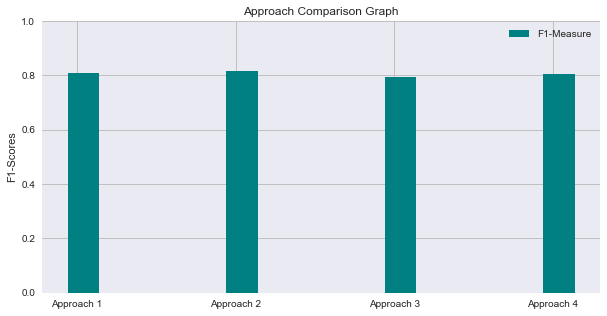

In [17]:
# Set the bar labels
bar_labels = ['Approach 1', 'Approach 2', 'Approach 3', 'Approach 4']

# Create the x position of the bars and give bar graph parameters
N=4
x_pos = np.arange(N)
width=0.2

# Create the plot bars
#accuracies=(accuracy_1,accuracy_2,accuracy_3,accuracy_4)
f1scores=(F1_1,F1_2,F1_3,F1_4)

#We can plot other performance factors along with F1-measures, therefore we can use subplots.
fig, ax =plt.subplots(figsize=(10,5))

# Plot a bar graph. 

plt.bar([p + width*1.2 for p in x_pos],# using the data from the mean_values
        f1scores, 
        # with a y-error lines set at variance
        width ,
        # aligned in the center
        color='teal'
        )


# add a grid
plt.grid(color='silver')

# set axes labels and title
ax.set_ylabel('F1-Scores')

# Set the chart's title
ax.set_title('Approach Comparison Graph')
ax.set_xticks([p + width for p in x_pos])
ax.set_xticklabels(bar_labels)
plt.ylim(0,1)
plt.legend(['F1-Measure'])
plt.show()

**RESULTS:
The Approach 2 gives the best F1-score as 0.8177. So, we can say the combination of Label based and Logistic Regression Classifier is good at the stack layer for this data**

## Grid Search Through SuperLearnerClassifier Architectures & Parameters (Task 7)

Perfrom a grid search experiment to detemrine the optimal architecture and hyper-parameter values for the SuperLearnClasssifier for the MNIST Fashion classification problem.

**Due to the limitation of computation power the Base model lists given to grid search is reduced to set of 3 Base Estimators. So in this way two lists of 3 base-types models is given as an input**

In [9]:
#Perform a Grid Search
"""
DESCRIPTION

Parameters:

1. modelslists       : It will take the lists of the base models combinations required for the Super Learner Classifier whose output will be used
                       to fill the stack layer.
2. aggregator        : This will take the classifier combinations used for training the stack layer.
3. probability_flag  : This will take the probability flag True or False to decide whether the label based or probability based
                       data needs to be send to stack layer.
"""


BaseModelsList_1=[DecTreeClf,LogClf,NBClf]
BaseModelsList_2=[DecTreeClf,KnnClf,SVMClf]


param_grid ={'modelslists': [BaseModelsList_1,BaseModelsList_2], \
             'aggregator': [DecTreeClf,LogClf],\
             'probability_flag': [True,False]  }

grid_superlearnerClf=SuperLearnerClassifier()

# Perform the grid search
my_tuned_superlearner = GridSearchCV(grid_superlearnerClf, \
                                param_grid, cv=cv_folds, verbose = 0, \
                            return_train_score=True)
my_tuned_superlearner.fit(X_train, y_train)

# Print details of grid searches
print("Best parameters set found on development set:")
display(my_tuned_superlearner.best_params_)
display(my_tuned_superlearner.best_score_)
display(my_tuned_superlearner.cv_results_)

Best parameters set found on development set:


{'aggregator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'modelslists': [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              presort=False, random_state=None, splitter='best'),
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  GaussianNB(priors=None)],
 'probability_flag': False}

0.80909090909090908

{'mean_fit_time': array([  31.78589125,   28.90822191,  148.83256917,  148.85872545,
          28.45852566,   28.38961043,  146.51124811,  164.28419819]),
 'mean_score_time': array([ 0.11634912,  0.12042036,  5.39656086,  5.3459455 ,  0.10867972,
         0.11869059,  5.33418112,  6.02206068]),
 'mean_test_score': array([ 0.76575758,  0.80393939,  0.75787879,  0.79424242,  0.75666667,
         0.80909091,  0.75121212,  0.79363636]),
 'mean_train_score': array([ 0.87582815,  0.94386489,  0.84409002,  0.86393951,  0.87628794,
         0.94417082,  0.85196868,  0.86106089]),
 'param_aggregator': masked_array(data = [ DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best')
  DecisionTreeClassifier(class_weight=None, criterion='gini', 

Evaluate the performance of the model selected by the grid search on a hold-out dataset

In [10]:
#Use the hold out dataset i.e in our case X_test  for the predictions

# Make a set of predictions for the test data
y_tuned_pred = my_tuned_superlearner.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_tuned_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_tuned_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_tuned_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.784444444444
             precision    recall  f1-score   support

          0       0.73      0.75      0.74       102
          1       0.94      0.91      0.92        87
          2       0.68      0.69      0.68        97
          3       0.72      0.76      0.74        93
          4       0.62      0.76      0.68        88
          5       0.84      0.87      0.86        85
          6       0.65      0.49      0.56        96
          7       0.91      0.87      0.89        94
          8       0.89      0.88      0.88        74
          9       0.94      0.92      0.93        84

avg / total       0.79      0.78      0.78       900

Confusion Matrix


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
True,,,,,,,,,,,
0,77,1,4,13,1,0,5,0,1,0,102
1,2,79,0,6,0,0,0,0,0,0,87
2,5,1,67,0,17,0,7,0,0,0,97
3,5,1,5,71,8,0,3,0,0,0,93
4,0,2,6,4,67,0,7,0,2,0,88
5,0,0,1,0,0,74,1,5,1,3,85
6,15,0,14,5,12,0,47,0,3,0,96
7,0,0,0,0,0,9,0,82,1,2,94
8,1,0,2,0,3,0,2,1,65,0,74


## Evaluating the Impact of Adding Original Descriptive Features at the Stack Layer (Task 8)

Evaluate the impact of adding original descriptive features at the stack layer.

In [11]:
"""
Now that we have got the best parameters combination from the above task (Grid Search). We will use this parameters 
combination to fit superlearner classifier and evaluate the impact after adding Original Descriptive Features at the Stack Layer
on the same data which was used for Grid Search.

"""

superlearnerClf_new=SuperLearnerClassifier(BaseModelsList_1,DecTreeClf,probability_flag=False,original_features=True)

superlearnerClf_new.fit(X_train,y_train)

y_pred_new = superlearnerClf_new.predict(X_valid)

accuracy_1 = metrics.accuracy_score(y_valid, y_pred_new) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy_1))

print(metrics.classification_report(y_valid, y_pred_new))

Accuracy: 0.728888888889
             precision    recall  f1-score   support

          0       0.75      0.67      0.70       102
          1       0.96      0.91      0.93        87
          2       0.60      0.63      0.61        97
          3       0.75      0.62      0.68        93
          4       0.59      0.58      0.59        88
          5       0.80      0.82      0.81        85
          6       0.44      0.53      0.48        96
          7       0.90      0.82      0.86        94
          8       0.73      0.86      0.79        74
          9       0.91      0.92      0.91        84

avg / total       0.74      0.73      0.73       900



**OBSERVATION OF TASK 8**

**The Accuracy score after adding Original Descriptive Features to Stack Layer decreases by some extent. The reason for the decrease can be because of the Curse of Dimentionality. So, as per the Curse of Dimentionality the more features you add there exists some point where your performance starts degrading. The same is happening in above case, adding more input features gave decreased accuracy i.e it degraded the performance than the performance of best tuned super learner classifier we got in the previous result.**

## Explore the Ensemble Model (Task 9)

Perform an analysis to investigate the strength of the base estimators and the strengths of the correlations between them.

In [12]:
#Again as declared earlier we can declare the classifier list

DecTreeClf= tree.DecisionTreeClassifier()
SVMClf= SVC(probability=True)
KnnClf=KNeighborsClassifier(5)
SGDClf=linear_model.SGDClassifier(loss='log')
LogClf=linear_model.LogisticRegression()
NBClf=naive_bayes.GaussianNB()
RFClf=RandomForestClassifier()
ADBClf=AdaBoostClassifier()
BagClf=BaggingClassifier()
MLPClf=MLPClassifier()

#We can use the following base estimators list to investigate the strength of the base estimators and the strengths of the correlations between them.
basemodellist1=[DecTreeClf,RFClf,KnnClf,NBClf,BagClf,LogClf]
basemodellist2=[DecTreeClf,SGDClf,SVMClf,KnnClf,NBClf,ADBClf]
basemodellist3=[SGDClf,LogClf,MLPClf,ADBClf,BagClf,KnnClf]


**Note: The base model list should be same as that used during fitting the Super Learner Classifier**

Correlation Matrix for Base Models


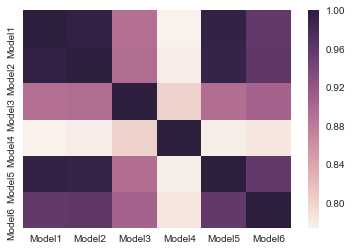

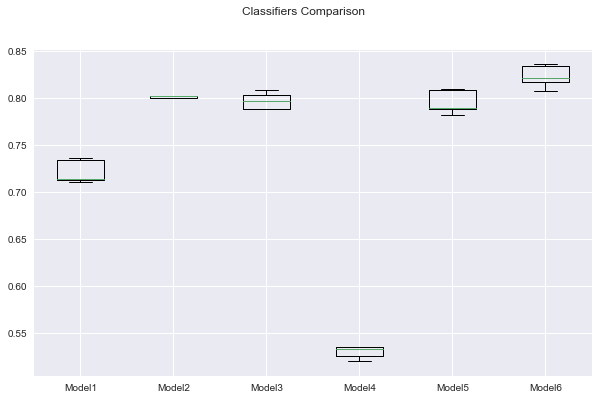

SuperLearnerClassifier(Vfold=None,
            aggregator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
            modelslists=[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_stat...lty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)],
            original_features=False, probability_flag=False)

In [14]:
clf=SuperLearnerClassifier(basemodellist1)
clf.fit(X_train,y_train)
clf.getBaseClassifierPerformance(X_train,y_train)

**TASK 9 RESULTS EXPLANATION**

** The diversity is calculated using the correlation matrix. The correlation method used is Spearman correlation. The Heat Map is used for visualizing the correlation scores amongst each base models. The high correlation scores means there is less diversity between two models.For example in above Heat Map Model 1 and Model 4 are less correlated(high diversity) than Model 1 and Model 2 high correlated(less diversity)**

**
The box plot is used to plot the performance measures here accuracy of the base estimators. Here Model 4 i.e Naive Bayes gives the least accuracy wheresas Logistic Regression Classifier gives highest accuracy amongst each other
**

**
Thus, this explains the ensemble concept i.e base estimators being strong predictors but at same time are weakly correlated with each other.**